# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

### I faced some problem with reading an original file by default pd csv reader or csv library. So I saved it again to csv with utf-8 encoding. But still faced problem, because of extra separation characters. Also I dealed with problem that in csv file used different quetochars for separating the text. And last problem was with dates encoding some them was in format YYYY-mm-dd others dd-mm-YYYY. In this way, I lost some records from table

## Data reading and preprocessing

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import string
from datetime import datetime

In [379]:
file_path = 'C:/data/sber/review.csv'
with open(file_path, 'r',encoding='utf-8') as file:
    lines = file.readlines()

In [380]:
def clean_from_html(text):
    lst = text.copy()
    result = []
    html_stuff = ['\xa0','ltpgt','\n','quot','lt p gt','p','lt','gt','br']
    for smthng in html_stuff:
        for i,string in enumerate(lst):
            string = re.sub(" +", " ", string).replace(smthng,"")
            lst[i] = string
    return lst

In [381]:
new_lines = []
punctuation = r'[^\w\s?!|,]'
for line in lines:
    line_with_sep = line.replace('|','').replace('"""&lt;p&gt;','|')
    line_cleaned = re.sub(punctuation,' ', line_with_sep)
    new_lines.append(line_cleaned)
new_lines = clean_from_html(new_lines)

In [382]:
new_lines[5]

' просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю '

In [383]:
text = ''.join(new_lines)

In [384]:
text_separated = text.split('|')

At the end of type separating has changed, so all records get to last element

In [385]:
last = text_separated[-1]

In [386]:
pattern = r'(\d{4} \d{2} \d{2} \d{2} \d{2} \d{2})'
split_text = re.split(pattern, last)

In [387]:
text[:1000]

' body,title,rating,bank_name,date |Добрый день  пишу сюда для более скорого разрешения вопроса  Пополнил через Юмани Озон банк  после чего вывести деньги не дал, сославшись на сомнительные операции понимаю, могло так показаться  просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю  документы предоставил, причины переводов тоже  надеюсь на разблокировку, если не для переводов, то хотя бы для оплаты товаров  для привлечения внимания пока ставлю 1  после решения вопроса поставлю 5 ,Заблокировали средства,1,Еком Банк,2023 01 03 12 46 11 |При возврате просроченной задолженности, банк звонит третьим лицам не указанным в договоре, ни как контактными, ни как поручителем или созаемщиком Звонки это пол беды, готовьтесь к тому, что банк озвучит всю сумму долга третьим лицам и потребует внести платеж сумму так же озвучит Ни отправленный отказ по взаимодействию с третьими лицами, ни обращение в службу поддержки б анка резу льтатов Вам не п ри несёт , Во зв ра

In [388]:
text_separated[2]

'При возврате просроченной задолженности, банк звонит третьим лицам не указанным в договоре, ни как контактными, ни как поручителем или созаемщиком Звонки это пол беды, готовьтесь к тому, что банк озвучит всю сумму долга третьим лицам и потребует внести платеж сумму так же озвучит Ни отправленный отказ по взаимодействию с третьими лицами, ни обращение в службу поддержки б анка резу льтатов Вам не п ри несёт , Во зв рат пр ос ро ченн ой задолженномти,1,Тинькофф Банк,2023 01 03 12 31 46'

In [389]:
for i in range(0,len(split_text)-2,2):
    data = ''.join(split_text[i:i+2])
    text_separated.append(data)

In [390]:
print(text_separated[0])
text_separated = text_separated[1:]

 body,title,rating,bank_name,date 


In [391]:
df_dict = {'body_with_title':[],'rating':[],'bank':[],'date':[], 
               'question_mark_counts':[],'exclamation_mark_counts':[],
               'capital_proportion':[]}
def data_from_list(lst):
    string = "".join(lst)
    pattern_1 = r'202\d'
    if string.isdigit() and re.match(pattern_1, string[:4]) and 0<int(string[4:6])<13:
        res = string[:4] + '-' + string[4:6]
        return res
    return None

def count_ratio_of_capital(text):
    count = 0
    for sign in text:
        if sign.isupper():
            count += 1
    return count/len(text)
def count_ratio_of_sign(string, sign):
    count = string.count(sign)
    return count/len(string)

for text_raw in text_separated:
    text_elements = text_raw.split(',')
    if len(text_elements)>3:
        if text_elements[-3].isdigit():
            data = text_elements[-1].split()
            data = data_from_list(data)
            df_dict['date'].append(data)
            bank_name = text_elements[-2].lower()
            df_dict['rating'].append(int(text_elements[-3]))
            body_with_title = ''.join(text_elements[:-3])
            quest_mark = count_ratio_of_sign(body_with_title,'?')
            excl_mark = count_ratio_of_sign(body_with_title,'!')
            punctuation = r'[^\w\s]'
            digits = r'[^\d]'
            text_without_punctuation = re.sub(punctuation, '', body_with_title)
            text_cleaned = re.sub(r'\d', '', text_without_punctuation)
            text_result = re.sub(' +', ' ',text_cleaned)
            bank_name_no_dig = re.sub(r'\d','',bank_name)
            bank_name_no_punc = re.sub(punctuation, '', bank_name_no_dig)
            bank_name_res = re.sub(' +', '',bank_name_no_punc)
            df_dict['bank'].append(bank_name_res.lower())
            df_dict['body_with_title'].append(text_result.lower())
            df_dict['question_mark_counts'].append(quest_mark)
            df_dict['exclamation_mark_counts'].append(excl_mark)
            df_dict['capital_proportion'].append(count_ratio_of_capital(text_result))
df = pd.DataFrame(df_dict)
df['length'] = df['body_with_title'].apply(lambda x:len(x))

## Data observation

In [392]:
df['date'].isna().sum()

5040

Because of problems with encoding, we obtained different types of markdowns about date, but we have arranged in an order (from latest to newest), so lets fill strange values by previous).

In [393]:
df['date'].iloc[:10]

0    2023-01
1    2023-01
2    2023-01
3    2023-01
4    2023-01
5       None
6    2023-01
7    2023-01
8    2023-01
9    2023-01
Name: date, dtype: object

In [394]:
df['date'].iloc[-10:]

74939    2022-09
74940    2022-09
74941    2022-09
74942    2022-09
74943    2022-09
74944    2022-09
74945    2022-09
74946    2022-09
74947    2022-09
74948    2022-09
Name: date, dtype: object

In [395]:
df['date'].value_counts()

2022-12    22638
2022-11    19917
2022-10    19673
2022-09     7065
2023-01      315
2022-01      297
2023-12        4
Name: date, dtype: int64

In [396]:
def replace_for_column(x):
    if x in ['2022-01','2023-12']:
        return None
    return x
date_column = df['date'].apply(lambda x: replace_for_column(x)).tolist()

In [397]:
for i in range(len(date_column)):
    if not date_column[i]:
        date_column[i] = date_column[i-1]

In [398]:
df['date'] = date_column

([0, 1, 2, 3, 4],
 [Text(0, 0, '2023-01'),
  Text(1, 0, '2022-12'),
  Text(2, 0, '2022-10'),
  Text(3, 0, '2022-11'),
  Text(4, 0, '2022-09')])

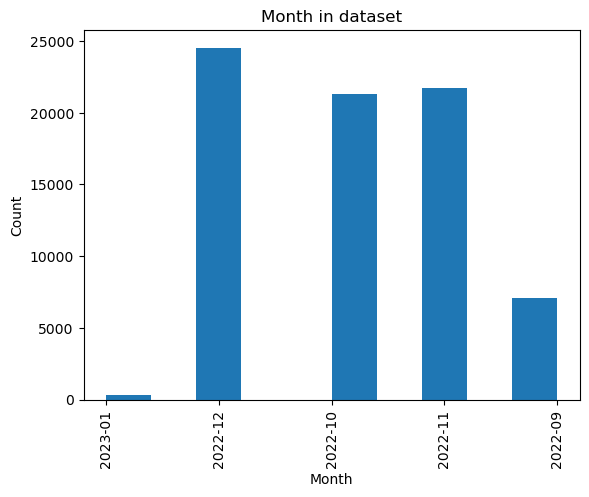

In [399]:
plt.hist(df['date'])
plt.title('Month in dataset')
plt.ylabel('Count')
plt.xlabel('Month')
plt.xticks(rotation=90)

The data shows 5 intervals per month

In [400]:
df['rating'].value_counts()

5    54111
1    15025
4     2867
2     1994
3      952
Name: rating, dtype: int64

In [401]:
df['body_with_title'].iloc[0]

'добрый день пишу сюда для более скорого разрешения вопроса пополнил через юмани озон банк после чего вывести деньги не дал сославшись на сомнительные операции понимаю могло так показаться просто озон удобен тем что можно пополнить его через qiwi и юмани без комиссии за что ценю документы предоставил причины переводов тоже надеюсь на разблокировку если не для переводов то хотя бы для оплаты товаров для привлечения внимания пока ставлю после решения вопроса поставлю заблокировали средства'

In [402]:
names = np.array(df['bank'].value_counts()[:15].index.tolist())
values = np.array(df['bank'].value_counts()[:15].values.tolist())

In [403]:
df

,body_with_title,rating,bank,date,question_mark_counts,exclamation_mark_counts,capital_proportion,length
0,добрый день пишу сюда для более скорого разреш...,1,екомбанк,2023-01,0.000000,0.000000,0.020367,491
1,при возврате просроченной задолженности банк з...,1,тинькоффбанк,2023-01,0.000000,0.000000,0.011261,444
2,ю была оформлена кредитная карта дней в банке...,1,банкоткрытие,2023-01,0.001742,0.011324,0.028651,1082
3,новый год начинается с приятностей никогда не ...,5,тинькоффбанк,2023-01,0.002188,0.003282,0.029748,874
4,увидела на сайте газпромбанка акцию с бонусом ...,1,газпромбанк,2023-01,0.000000,0.000000,0.019157,522
...,...,...,...,...,...,...,...,...
74944,августа обнаружила что баланс уменьшился в ис...,1,совкомбанк,2022-09,0.003018,0.004024,0.029412,952
74945,обратился с вопросом по all airlines только з...,5,тинькоффбанк,2022-09,0.000000,0.000000,0.025882,425
74946,в августе я досрочно погасил ипотеку кредитны...,2,россельхозбанк,2022-09,0.000000,0.003515,0.010979,1093
74947,оформлен кредит на покупку автомобиля в салон...,1,драйвкликбанк,2022-09,0.002730,0.000910,0.013848,1011


In [404]:
banks_rating = dict(df.groupby('bank')['rating'].mean())

In [405]:
banks_rating

{'абсолютбанк': 4.555160142348755,
 'авангард': 2.107142857142857,
 'аверс': 5.0,
 'автокредитбанк': 4.714285714285714,
 'агора': 3.0,
 'агропромкредит': 5.0,
 'агророс': 3.6,
 'азиатскоимяихоокеанскийбанк': 5.0,
 'азиатскоимяокеанскийбанк': 5.0,
 'азиатскоимяоокеанскийбанк': 5.0,
 'азиатскоимяхоокеанскийбанк': 4.0,
 'азиатскотихоокеанскийбанк': 4.666666666666667,
 'акбарс': 1.4375,
 'акибанк': 3.0,
 'александровский': 2.25,
 'алефбанк': 1.0,
 'алмазэргиэнбанк': 1.0,
 'альфабанк': 1.7249262536873156,
 'альфаимяанк': 2.2857142857142856,
 'альфаимяк': 1.5714285714285714,
 'альфаимянк': 3.0,
 'балтинвестбанк': 3.0,
 'банкакцепт': 4.1,
 'банкглобус': 3.0,
 'банкдомрф': 3.6238805970149253,
 'банкжилищногофинансирования': 3.3142857142857145,
 'банкзенит': 3.9642857142857144,
 'банкинтеза': 1.3333333333333333,
 'банкказани': 4.2,
 'банкоранжевый': 1.0,
 'банкоткрытие': 3.5109926715522985,
 'банкпермь': 1.0,
 'банкраунд': 1.0,
 'банксанктпетербург': 3.295302013422819,
 'банксинараскббанк': 2.4

In [406]:
ratings = [banks_rating[i] for i in names]

Text(0.5, 1.0, 'Numbers of reviews and Mean Rating per top-15 banks')

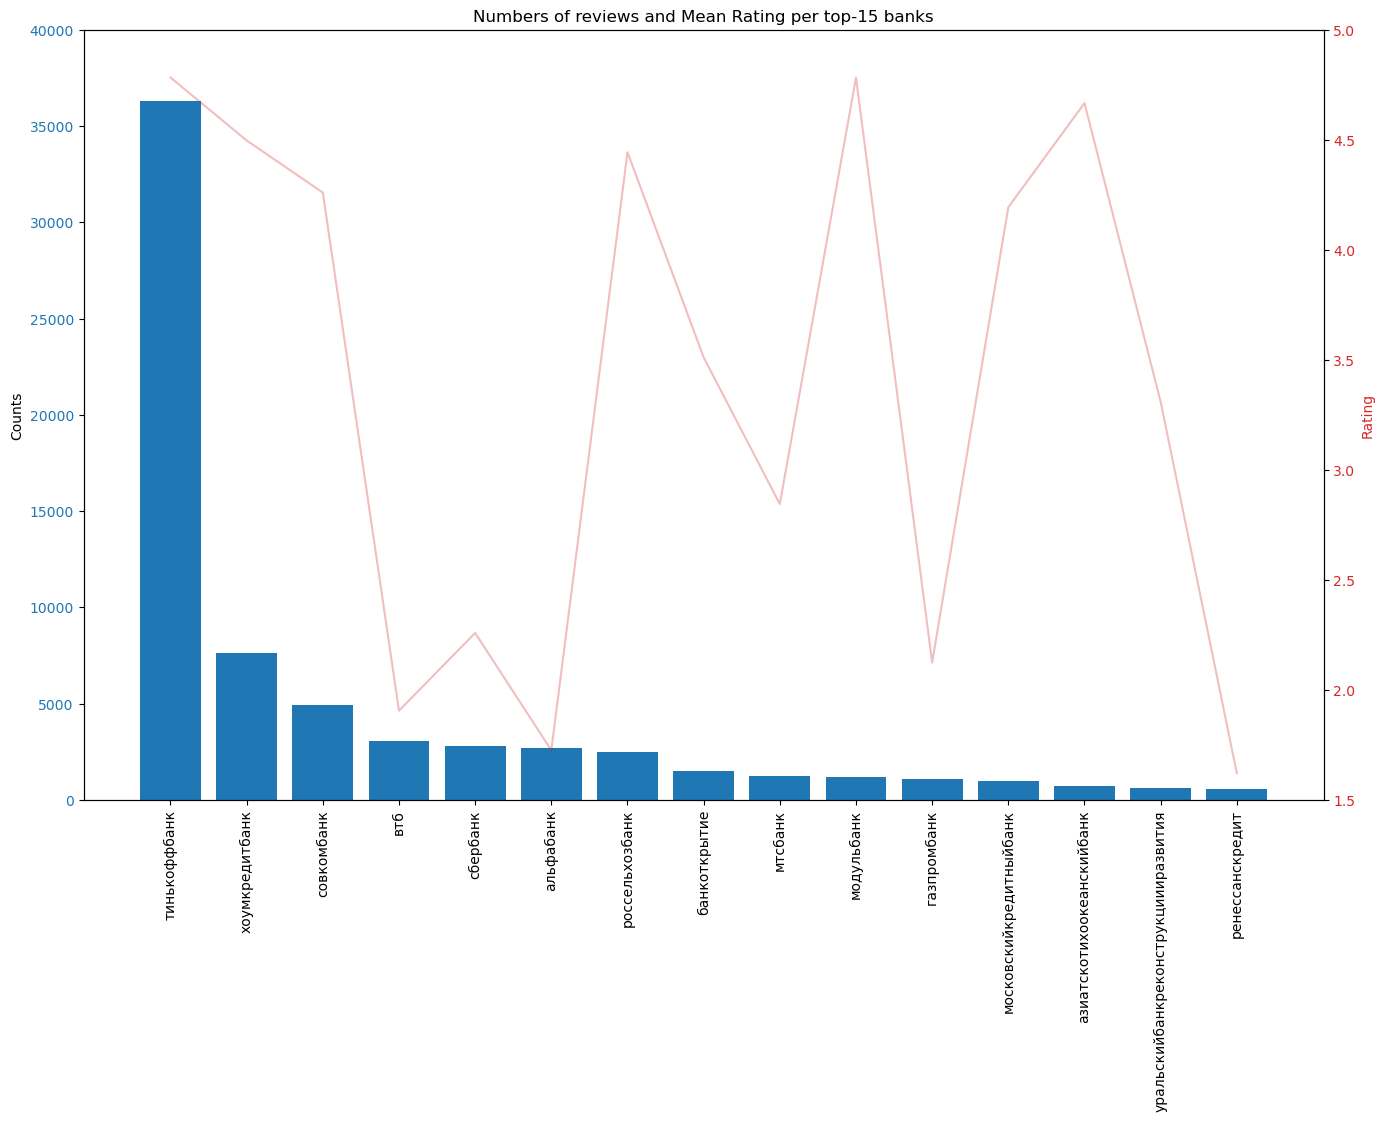

In [407]:
fig, ax1 = plt.subplots(figsize=(16,10))
color = 'tab:blue'
ax1.bar(x=names,height=values,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Counts')
ax1.set_ylim(0,40000)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Rating', color=color)  
ax2.plot(names, ratings, color=color,alpha=.3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1.5,5)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
plt.title('Numbers of reviews and Mean Rating per top-15 banks')

From plot It becomes visible, that main part of reviews is Related to Tinkoff bank by a significant margin. Also this bank has the bigger mean rating of all from top-15

In [408]:
banks_rating['тинькоффбанк']

4.783269018743109

In [409]:
banks_rating['модульбанк']

4.7822847682119205

In [410]:
top_5_names = names[:5]
top_5_names

array(['тинькоффбанк', 'хоумкредитбанк', 'совкомбанк', 'втб', 'сбербанк'],
      dtype='<U35')

In [411]:
df_top_5 = df[df['bank'].apply(lambda x: x in top_5_names)]

In [412]:
df_top_5.shape

(54728, 8)

In [413]:
monthly_count = df_top_5.groupby(['date','bank'])['rating'].mean()

In [414]:
monthly_count

date     bank          
2022-09  втб               2.066528
         сбербанк          1.918489
         совкомбанк        3.852564
         тинькоффбанк      3.832447
         хоумкредитбанк    3.927273
2022-10  втб               1.807560
         сбербанк          2.758824
         совкомбанк        3.926829
         тинькоффбанк      4.879856
         хоумкредитбанк    3.786842
2022-11  втб               1.975225
         сбербанк          2.556497
         совкомбанк        4.167691
         тинькоффбанк      4.839557
         хоумкредитбанк    4.063380
2022-12  втб               1.847411
         сбербанк          1.851642
         совкомбанк        4.499182
         тинькоффбанк      4.639200
         хоумкредитбанк    4.610875
2023-01  втб               1.153846
         сбербанк          1.400000
         совкомбанк        4.482759
         тинькоффбанк      3.955056
         хоумкредитбанк    3.000000
Name: rating, dtype: float64

In [415]:
banks = df_top_5.bank.unique()

In [416]:
mean_rating = df_top_5.groupby('date').rating.mean()

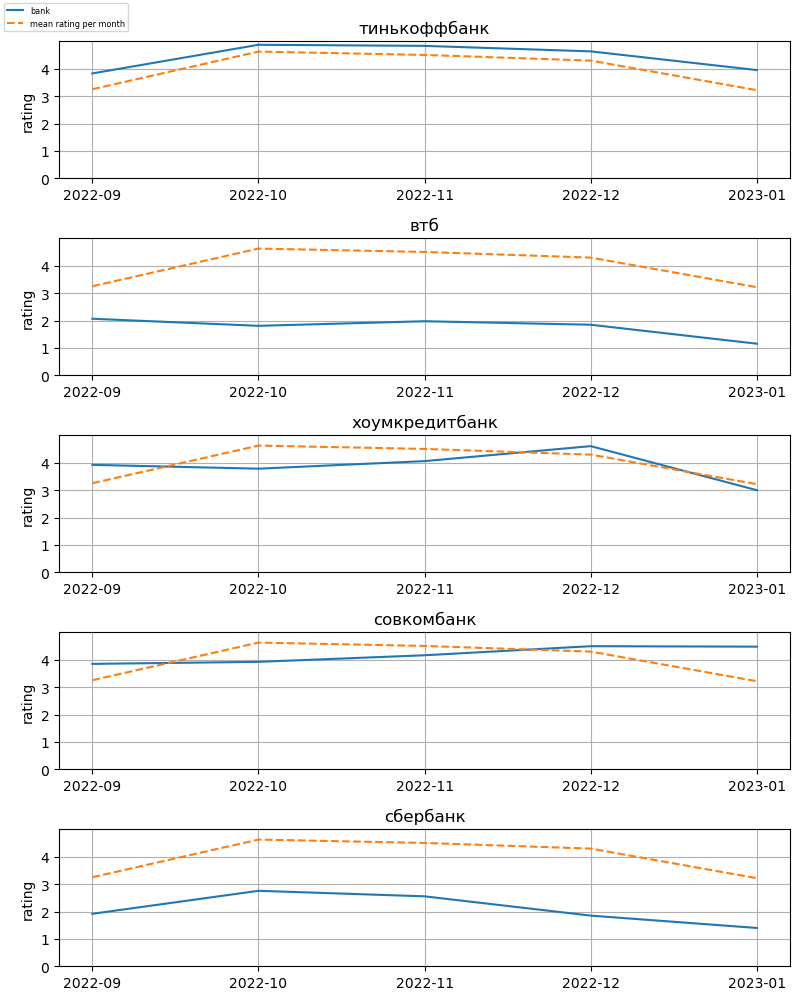

In [417]:
fig, axs = plt.subplots(5,1,figsize=(8,10))
for i,bank in enumerate(banks):
    df_bank = df_top_5[df_top_5['bank']==bank]
    res = df_bank.groupby('date').rating.mean()
    if i==0:
        axs[i].plot(res,label='bank')
        axs[i].plot(mean_rating,'--',label='mean rating per month')
    else:
        axs[i].plot(res)
        axs[i].plot(mean_rating,'--')
    axs[i].set_ylim(0,5)
    axs[i].set_ylabel('rating')
    axs[i].set_yticks(range(5))
    axs[i].set_title(bank)
    axs[i].grid()
    axs[i].set_xticks(res.index)
plt.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc='upper left',fontsize='xx-small')
plt.show()

Tinkoff and sberbank rating of review, follows mean rating (of top-5). It's obvious for Tinkoff, the share of which is about 70% of total reviews. Also mean rating per bank is changing from month to month.

In [418]:
def get_label(value):
    if value>2:
        return "pos"
    return 'neg'
df['label'] = df['rating'].apply(get_label)

Text(0.5, 1.0, 'Labels distribution')

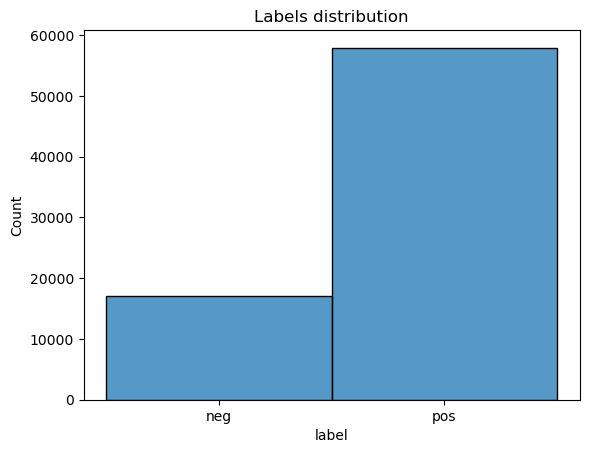

In [419]:
sns.histplot(df['label'])
plt.title('Labels distribution')

In [420]:
#!pip install wordcloud
import wordcloud 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [421]:
positive_text_series = df[df['label']=='pos'].body_with_title
positive_text = ' '.join(positive_text_series)
negative_text_series = df[df['label']=='neg'].body_with_title
negative_text = ' '.join(negative_text_series)

(-0.5, 919.5, 858.5, -0.5)

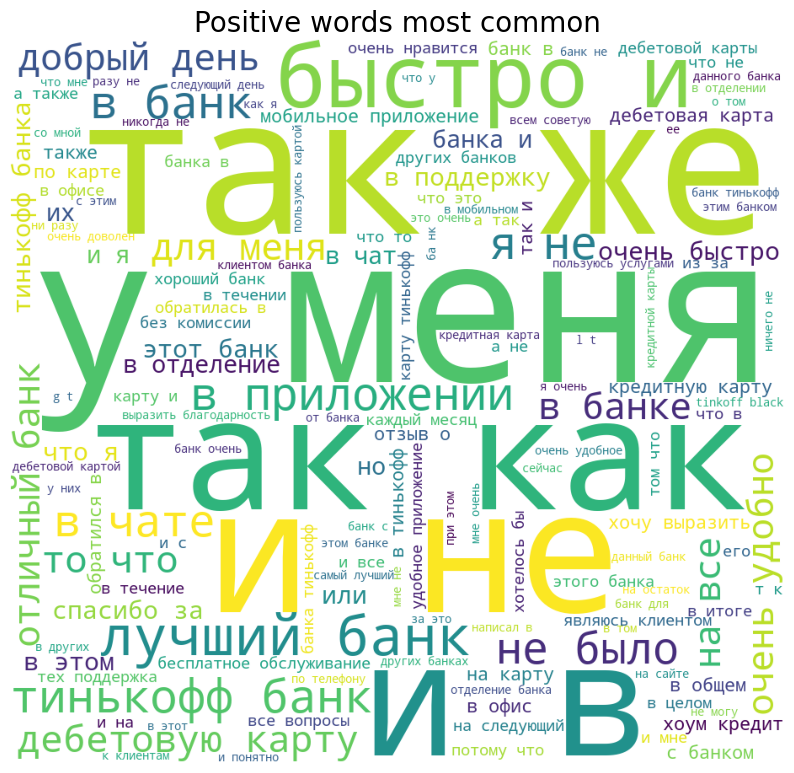

In [434]:
plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white', max_words=150, mask=bank_mask)
wc.generate(positive_text)

plt.imshow(wc)
plt.title('Positive words most common',fontsize=20)
plt.axis('off')

(-0.5, 919.5, 858.5, -0.5)

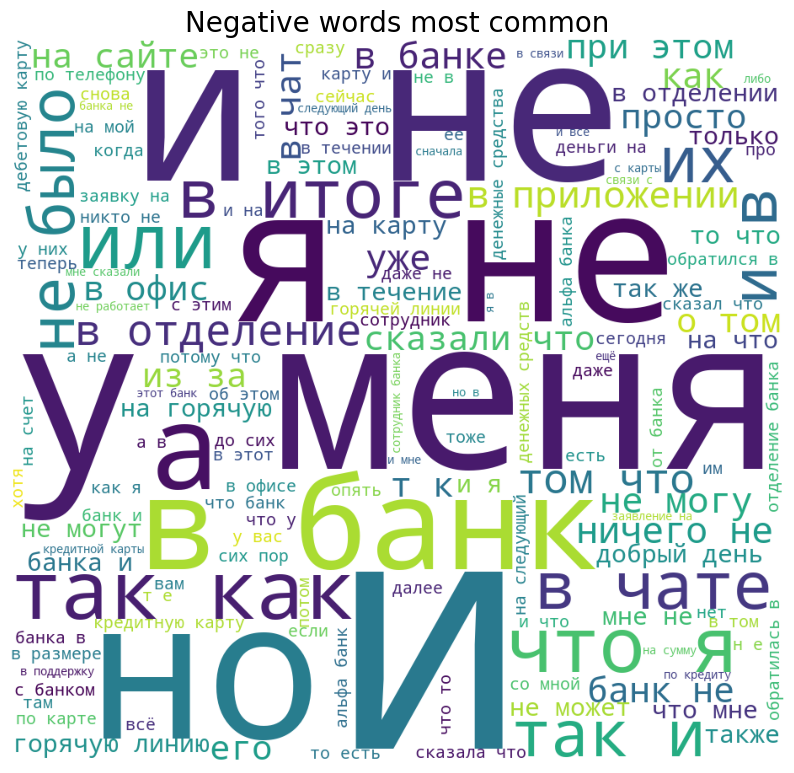

In [435]:
plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white', max_words=150, mask=bank_mask)
wc.generate(negative_text)

plt.imshow(wc)
plt.title('Negative words most common',fontsize=20)
plt.axis('off')

Text(0.5, 1.0, 'mean exclamation mark ratio per rating')

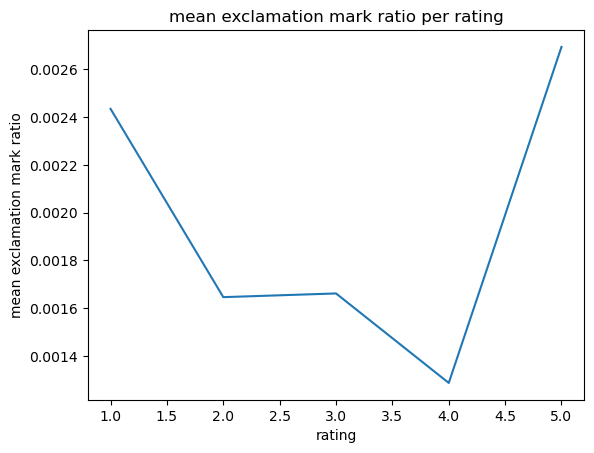

In [424]:
df.groupby('rating').exclamation_mark_counts.mean().plot()
plt.ylabel('mean exclamation mark ratio')
plt.title('mean exclamation mark ratio per rating')

Text(0.5, 1.0, 'mean question mark ratio per rating')

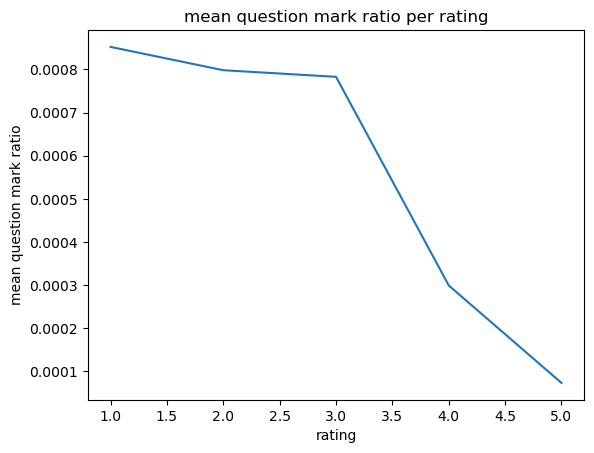

In [425]:
df.groupby('rating').question_mark_counts.mean().plot()
plt.ylabel('mean question mark ratio')
plt.title('mean question mark ratio per rating')

Text(0.5, 1.0, 'mean length per rating')

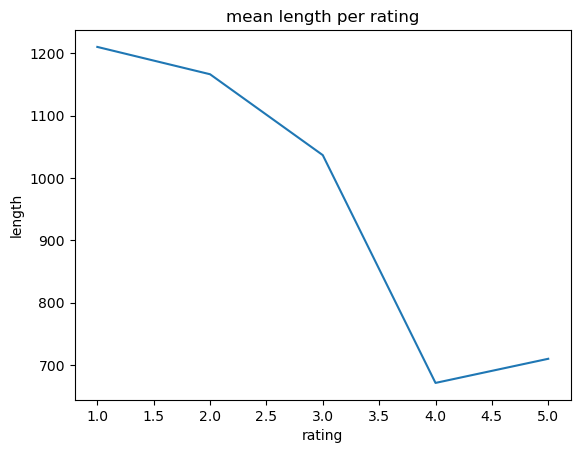

In [426]:
df.groupby('rating').length.mean().plot()
plt.ylabel('length')
plt.title('mean length per rating')

Text(0.5, 1.0, 'mean capital proportion')

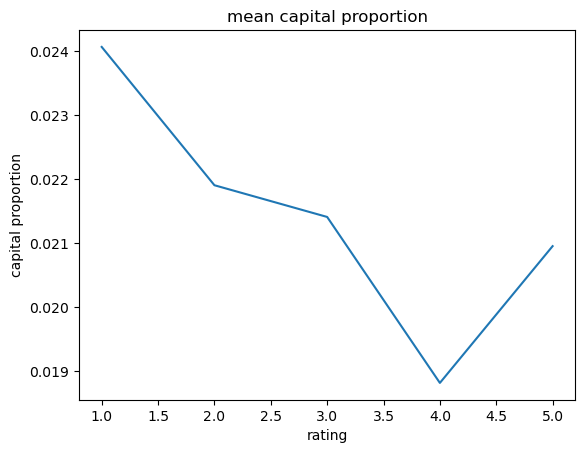

In [427]:
df.groupby('rating').capital_proportion.mean().plot()
plt.ylabel('capital proportion')
plt.title('mean capital proportion')

Based on previous plots we can try to build a classifier without text data, using only information about punctuation and ration of capital letters

### Simple baseline based on length, capital proportion and !,? marks

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
y = 1*(df.rating>2)
X = df[['question_mark_counts', 'exclamation_mark_counts', 'capital_proportion', 'length']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score

scaler = StandardScaler()
model = LogisticRegression(C=0.1)

In [52]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1)

In [53]:
pred = model.predict_proba(X_test_scaled)

In [54]:
pred_proba = pred[:, 1]

In [55]:
auc_score = roc_auc_score(y_test, pred_proba)

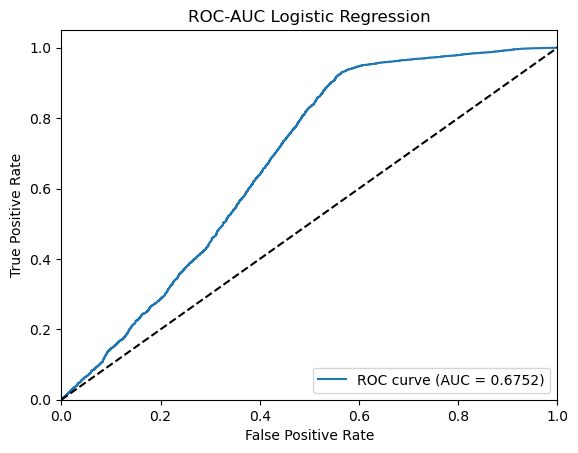

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Logistic Regression')
plt.legend(loc="lower right")
plt.show()

performance is poor, we need to analyze a text data

## Simple baseline TF-IDF 

In [57]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import requests

In [175]:
def plot_feautre_importance(model, tf_idf, k=5):
    feature_importance = model.coef_[0]
    voc = tf_idf.vocabulary_
    feature_names = [k for k, v in sorted(voc.items(), key=lambda item: item[1])]
    sorted_features_pos = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:k]
    names_pos = [f[0] for f in sorted_features_pos]
    scores_pos = [f[1] for f in sorted_features_pos]

    sorted_features_neg = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=False)[:k]
    names_neg = [f[0] for f in sorted_features_neg]
    scores_neg = [f[1] for f in sorted_features_neg]

    plt.figure(figsize=(10, 6))
    plt.bar(names_pos, scores_pos)
    plt.bar(names_neg, scores_neg)
    plt.title(f'Top {k*2} Most Important Words')
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)
    plt.show();

In [176]:
tf_idf = TfidfVectorizer(min_df=50,  max_features=None,analyzer='word',ngram_range=(1, 2))

In [177]:
y = 1*(df.rating>2)
X = df['body_with_title']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [178]:
train_tokenized = tf_idf.fit_transform(X_train)
test_tokenized = tf_idf.transform(X_test)

In [179]:
model.fit(train_tokenized, y_train)

LogisticRegression()

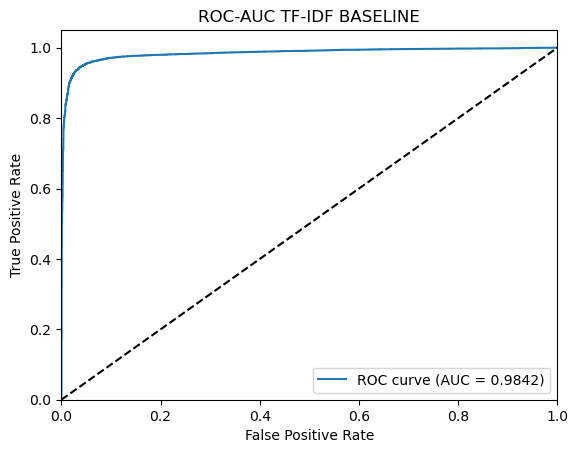

In [180]:
pred_proba = model.predict_proba(test_tokenized)[:, 1]
auc_score = roc_auc_score(y_test, pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC TF-IDF BASELINE')
plt.legend(loc="lower right")
plt.show()

In [181]:
auc_score

0.9841746988697206

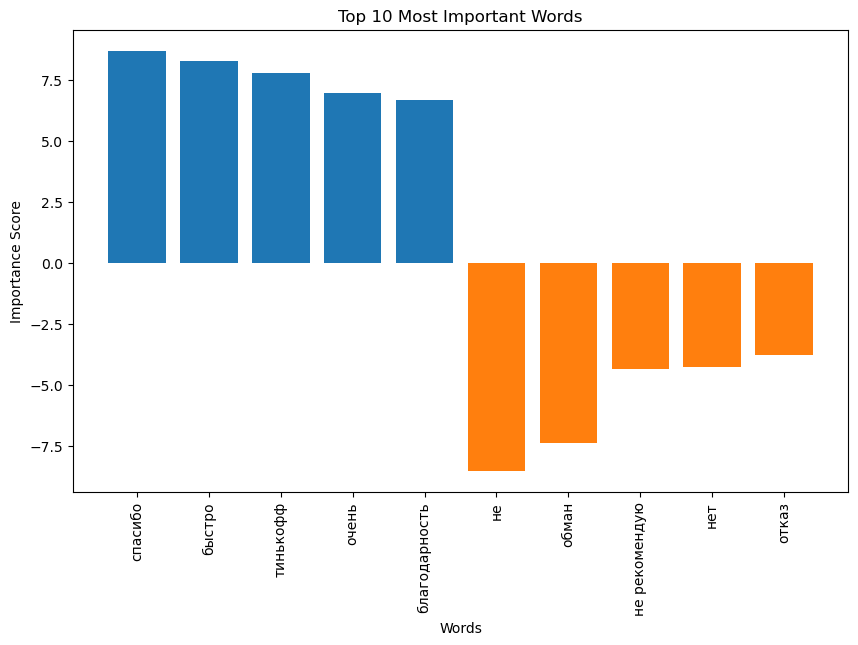

In [182]:
plot_feautre_importance(model, tf_idf, 5)

## Baseline TF-IDF with removing stopwords and lemmanization

In [183]:
with open('c:/data/sber/stop_words.txt',encoding='utf-8') as f:
    stop_words = f.readlines()

In [184]:
def find_most_common_words(series,n=5):
    words_dict = {}
    for text in series:
        words = text.split()
        for word in words:
            if word in words_dict.keys():
                words_dict[word] += 1
            else:
                words_dict[word] = 1
    words_dict =  sorted(words_dict.items(), key=lambda x: x[1],reverse=True)[:n]    
    return words_dict

In [185]:
additional_words_count = find_most_common_words(X)

In [186]:
additional_words = {pair[0] for pair in additional_words_count}

In [187]:
stop_words = {word[:-1] for word in stop_words}.union(additional_words)

In [188]:
len(stop_words)

1350

In [189]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token and token not in stop_words:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return ' '.join(tokens)
    return None

In [190]:
X_train[0]

'добрый день пишу сюда для более скорого разрешения вопроса пополнил через юмани озон банк после чего вывести деньги не дал сославшись на сомнительные операции понимаю могло так показаться просто озон удобен тем что можно пополнить его через qiwi и юмани без комиссии за что ценю документы предоставил причины переводов тоже надеюсь на разблокировку если не для переводов то хотя бы для оплаты товаров для привлечения внимания пока ставлю после решения вопроса поставлю заблокировали средства'

In [191]:
X_train_lem = X_train.apply(lemmatize)
X_test_lem = X_test.apply(lemmatize)

In [192]:
X_train_lem[0]

'добрый писать скорый вопрос пополнить юманя озон банк вывести дать сослаться сомнительный операция понимать показаться озон удобный пополнить qiwi юманя комиссия ценить документ предоставить перевод разблокировка перевод оплата товар привлечение внимание ставить решение вопрос поставить заблокировать средство'

In [193]:
sum(X_train_lem.isna())

0

In [194]:
y_train_lem = y_train[X_train_lem.notna()]
y_test_lem = y_test[X_test_lem.notna()]
X_train_lem = X_train_lem[X_train_lem.notna()]
X_test_lem = X_test_lem[X_test_lem.notna()]

In [195]:
train_tokenized = tf_idf.fit_transform(X_train_lem)
test_tokenized = tf_idf.transform(X_test_lem)

In [196]:
model_lem = LogisticRegression(C=0.1)

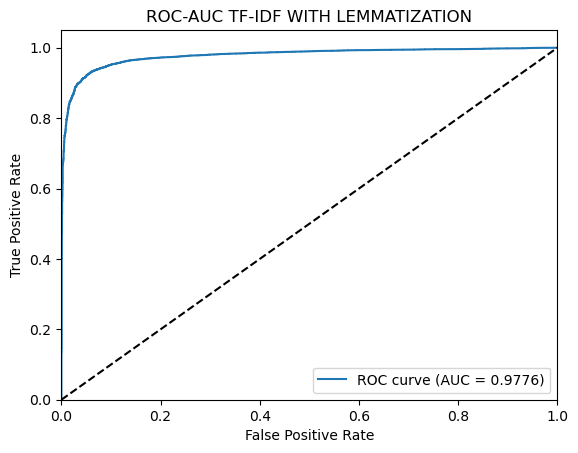

In [197]:
model_lem.fit(train_tokenized, y_train_lem)
pred_proba = model_lem.predict_proba(test_tokenized)[:, 1]
auc_score = roc_auc_score(y_test_lem, pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_lem, pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC TF-IDF WITH LEMMATIZATION')
plt.legend(loc="lower right")
plt.show()

In [198]:
auc_score

0.9775583778407895

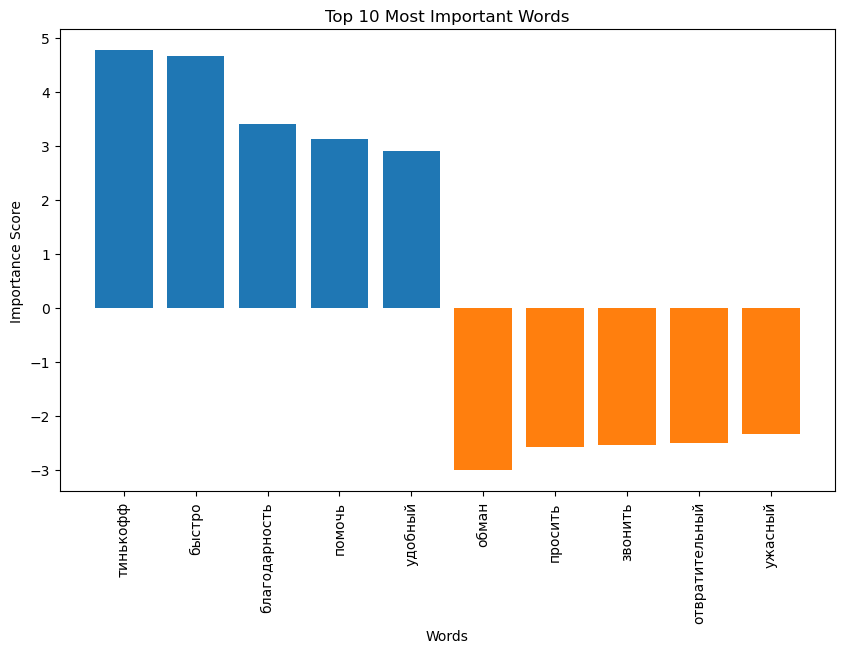

In [199]:
plot_feautre_importance(model_lem, tf_idf, 5)

### Results of TF-IDF with lemmatization and without lemmatization is good. Lemmatization and dropping of stop words didn't give signifficant improve. So let's try to fine-tune best model 
ROC-AUC

TF-IDF BASELINE 0.9842

TF-IDF Lemmatization 0.9776

In [224]:
model = LogisticRegression()
param_grid = {'C':np.logspace(-3,3,50)}
train_tokenized = tf_idf.fit_transform(X_train)
test_tokenized = tf_idf.transform(X_test)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(train_tokenized,y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.599858...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring='roc_auc')

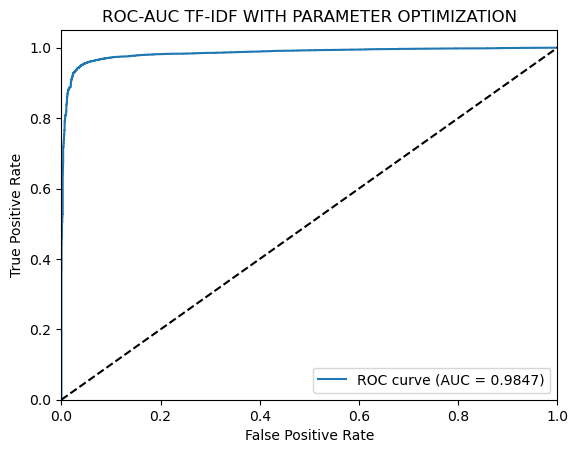

In [225]:
pred_proba = grid_search.best_estimator_.predict_proba(test_tokenized)[:, 1]
auc_score = roc_auc_score(y_test, pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC TF-IDF WITH PARAMETER OPTIMIZATION')
plt.legend(loc="lower right")
plt.show()

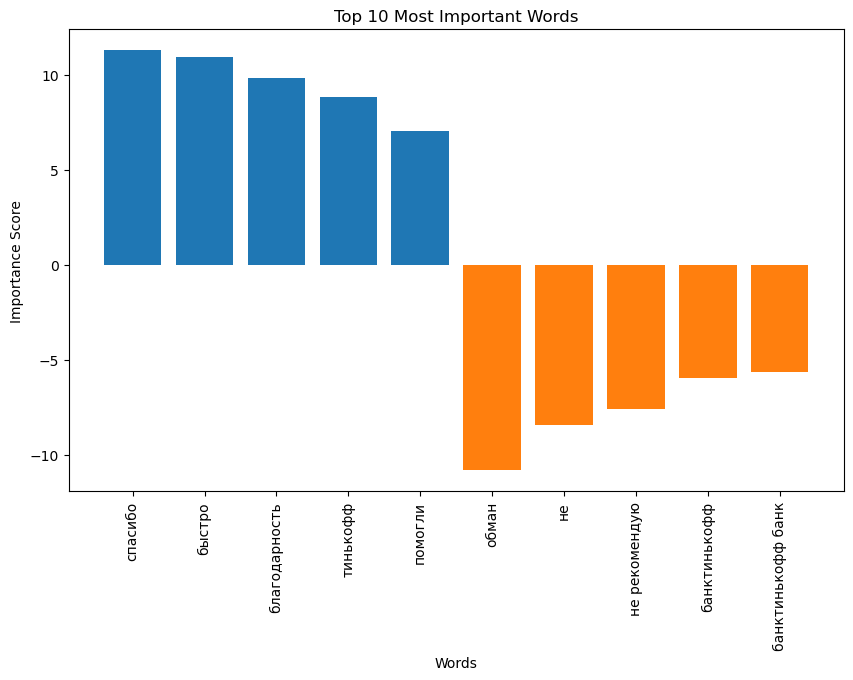

In [226]:
plot_feautre_importance(grid_search.best_estimator_, tf_idf, 5)

In [227]:
auc_score

0.9846711396285845

In [217]:
pred = grid_search.best_estimator_.predict(test_tokenized)

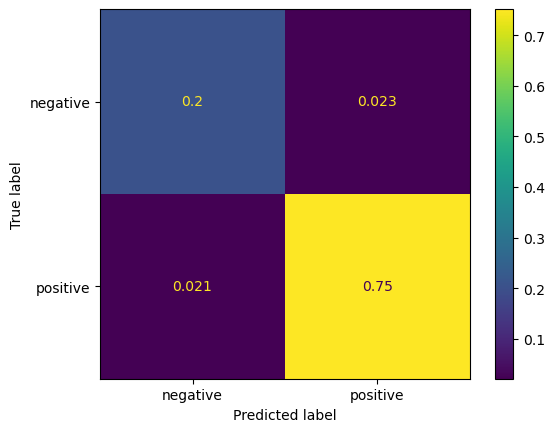

In [229]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
cmd.plot()

In [232]:
incorrect = X_test[y_test!=pred]

In [246]:
y_test_incorrect = np.array(y_test[y_test!=pred])
pred_incorrect = pred[y_test!=pred]

In [265]:
print(incorrect.iloc[0])
print('True value',y_test_incorrect[0])
print('Predicted',pred_incorrect[0])

добрый день меня зовут марина сегодня обратилась в отделение банка в г райчихинск за оформлением кредитной карты вопрос был решен быстро без предоставления каких либо дополнительных справок и документов спасибо менеджеру юлии за профессионализм и подробную информацию о полученной карте и о тарифах отзыв об обслуживании 
True value 0
Predicted 1


In [273]:
incorrect_df = df.loc[incorrect.index]

In [358]:
bank_count = dict(df.groupby('bank')['rating'].count())

In [294]:
bank_error_count = dict(incorrect_df.groupby('bank')['label'].count())

In [359]:
normalized = {k:(5*v/bank_count[k]) for k,v in bank_error_count.items() if k in top_5_names} 
# coefficient 5 is taken because we want to take only test dataframe, assuming distribution is the same
# we took 20%, so it's normalizing

In [360]:
normalized

{'втб': 0.10396361273554255,
 'сбербанк': 0.10896748838871026,
 'совкомбанк': 0.060790273556231005,
 'тинькоффбанк': 0.020672546857772877,
 'хоумкредитбанк': 0.0392875851231011}

In [352]:
normalized_list = np.array(sorted(normalized.items(),key=lambda x: -x[1]))

(0.0, 0.02288317261263728)

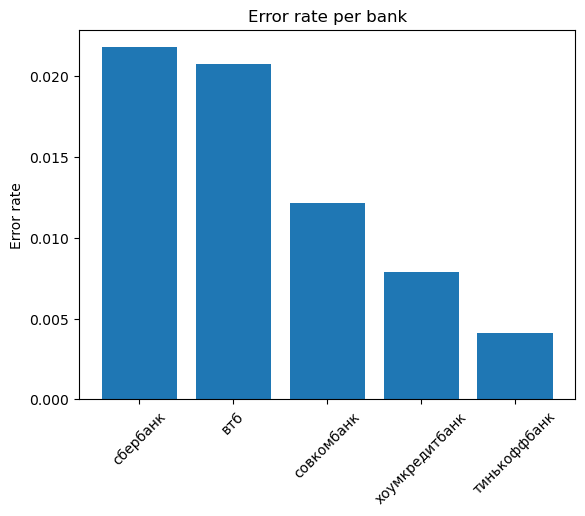

In [433]:
plt.bar(normalized_list[:,0],normalized_list[:,1].astype(np.float32))
plt.xticks(rotation=45)
plt.title('Error rate per bank')
plt.ylabel('Error rate')
plt.ylim(0)

### Part of erros occurs because due to rating errors (the factor of accidental error and imperfection of data). Also fo some banks as SBER and VTB, error rate is more than form home credit or tinkoff, I think this happens bcs their reviews had smaller amount of occurs + their mean rating is much less than Tinkoff and lies between pos/neg, but this statement requires a deeper analysis

### Posibility for improvment/future plans

1. Larger hyperparameter search (Grid/optuna)
2. Boosting models for classification (XGB, LGBM) + * ensemble of boostings
3. Recurent Neural networks classification (LSTM/GRU)
4. Transformer classification (BERT)
5. Dim reduction technics + SVM
6. TF-IDF hyperparameter search + change preprocessing of data